# Building a VQA system from scratch

In [ ]:
!pip install datasets transformers[torch] wandb torchvision

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import AutoModel, ViTModel, AutoModelForCausalLM, Trainer, TrainingArguments, ViTModel, ViTFeatureExtractor, AutoTokenizer
import torch.nn as nn

import os

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
DECODER_MODEL = 'gpt2'
TEXT_ENCODER_MODEL = 'distilbert-base-uncased'
IMAGE_ENCODER_MODEL = "facebook/dino-vitb16"

In [ ]:
decoder_tokenizer = AutoTokenizer.from_pretrained(DECODER_MODEL)
decoder_tokenizer.pad_token = decoder_tokenizer.eos_token
decoder_tokenizer.padding_side = "left"

In [ ]:
import torch.nn.functional as F

class MultiModalModel(nn.Module):
    """
    A MultiModalModel class used to perform visual question answering (VQA).
    It consists of encoders for text and image and a decoder for generating the answer.

    Attributes:
        text_encoder: A model to encode text input.
        image_encoder: A model to encode image input.
        decoder: A model to decode and generate answers.
        text_projection: A linear layer to project text encoding to a specific size.
        image_projection: A linear layer to project image encoding to a specific size.
    """

    def __init__(self, text_encoder_model, image_encoder_model, decoder_model, freeze=None, load_from=None):
        """
        Initialize the MultiModalModel.

        Parameters:
            text_encoder_model (str): Pre-trained text encoder model name.
            image_encoder_model (str): Pre-trained image encoder model name.
            decoder_model (str): Pre-trained decoder model name.
            freeze (str, optional): Which parts of the model to freeze. Can be 'encoders', 'decoder', 'all' or specific encoder.
            load_from (str, optional): Path to a checkpoint file to load the model.
        """
        super(MultiModalModel, self).__init__()

        # Initialize text and image encoders
        self.text_encoder = AutoModel.from_pretrained(text_encoder_model).to(device)
        self.image_encoder = ViTModel.from_pretrained(image_encoder_model).to(device)

        # Initialize the GPT-2 decoder
        self.decoder = AutoModelForCausalLM.from_pretrained(
            decoder_model,
            add_cross_attention=True,
            tie_word_embeddings=True
        ).to(device)

        # Initialize linear layers for projecting encoded features
        self.text_projection = nn.Linear(self.text_encoder.config.hidden_size, self.decoder.config.hidden_size).to(device)
        self.image_projection = nn.Linear(self.image_encoder.config.hidden_size, self.decoder.config.hidden_size).to(device)

        # Freeze specified encoders if required or load from a checkpoint
        if load_from:
            self.load_model_checkpoint(load_from)
        else:
            self.freeze(freeze)

    def freeze(self, freeze):
        """
        Freeze specific parts of the model to prevent them from being updated during training.

        Parameters:
            freeze (str): Which parts to freeze. Can be 'encoders', 'decoder', 'all', or specific encoder.
        """
        if not freeze or freeze == 'nothing':
            return

        print('Freezing...')
        if freeze in ('encoders', 'all') or 'text_encoder' in freeze:
            print('Freezing text encoder')
            for param in self.text_encoder.parameters():
                param.requires_grad = False

        if freeze in ('encoders', 'all') or 'image_encoder' in freeze:
            print('Freezing image encoder')
            for param in self.image_encoder.parameters():
                param.requires_grad = False

        if freeze in ('decoder', 'all'):
            print('Freezing decoder (except for cross attention)')
            for name, param in self.decoder.named_parameters():
                if "crossattention" not in name:
                    param.requires_grad = False

    def load_model_checkpoint(self, path):
        """
        Load the model from a saved checkpoint.

        Parameters:
            path (str): Path to the saved checkpoint.
        """
        checkpoint = torch.load(path)
        checkpoint = {k.replace("module.", ""): v for k, v in checkpoint.items()}
        self.load_state_dict(checkpoint)

    def check_input(self, tensor, tensor_name):
        """
        Check if there are any NaN or infinite values in the input tensor.

        Parameters:
            tensor (torch.Tensor): Input tensor.
            tensor_name (str): Name of the tensor for error logging.
        """
        if torch.isnan(tensor).any() or torch.isinf(tensor).any():
            print(f"NaN or infinite values found in {tensor_name}")

    def encode_text(self, input_text, attention_mask):
        """
        Encode text using the text encoder and project it to a specific size.

        Parameters:
            input_text (torch.Tensor): Input text tensor.
            attention_mask (torch.Tensor): Attention mask for the input text.

        Returns:
            torch.Tensor: Projected text encoding.
        """
        self.check_input(input_text, "input_text")
        text_encoded = self.text_encoder(input_text, attention_mask=attention_mask).last_hidden_state.mean(dim=1)
        return self.text_projection(text_encoded)

    def encode_image(self, input_image):
        """
        Encode image using the image encoder and project it to a specific size.

        Parameters:
            input_image (torch.Tensor): Input image tensor.

        Returns:
            torch.Tensor: Projected image encoding.
        """
        self.check_input(input_image, "input_image")
        image_encoded = self.image_encoder(input_image).last_hidden_state.mean(dim=1)
        return self.image_projection(image_encoded)

    def forward(self, input_text, input_image, decoder_input_ids, attention_mask, labels=None):
        """
        Forward pass through the model.

        Parameters:
            input_text (torch.Tensor): Input text tensor.
            input_image (torch.Tensor): Input image tensor.
            decoder_input_ids (torch.Tensor): Decoder input IDs tensor.
            attention_mask (torch.Tensor): Attention mask for the input text.
            labels (torch.Tensor, optional): Ground truth labels for the target.

        Returns:
            torch.Tensor: Decoder output.
        """
        self.check_input(decoder_input_ids, "decoder_input_ids")

        # Encode text and image
        text_projected = self.encode_text(input_text, attention_mask)
        image_projected = self.encode_image(input_image)

        # Combine encoded features
        combined_features = (text_projected + image_projected) / 2

        # Decode with GPT-2
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            labels=labels,
            encoder_hidden_states=combined_features.unsqueeze(1)
        )
        return decoder_outputs

    def generate(self, image, questions, max_text_length=5, verbose=True):
        """
        Generate answers for the given image and list of questions.

        Parameters:
            image (Image): Input image.
            questions (list): List of questions related to the image.
            max_text_length (int, optional): Maximum text length for generated answers.

        Returns:
            Image: Input image.
        """
        # Encode text and image
        image = retrieve_image(image)
        image_input = image_feature_extractor(images=[preprocess_image(image)], return_tensors="pt")
        input_image = image_input["pixel_values"].to(device)
        image_projected = self.encode_image(input_image).to(device)

        for question in questions:
            i = text_tokenizer(question, return_tensors='pt')
            text_projected = self.encode_text(i['input_ids'].to(device), i['attention_mask'].to(device)).to(device)

            # Combine encoded features
            combined_features = (text_projected + image_projected) / 2

            generated_so_far = torch.LongTensor([[decoder_tokenizer.bos_token_id]]).to(device)
            with torch.no_grad():
                for _ in tqdm(range(max_text_length)) if verbose else range(max_text_length):

                    decoder_outputs = self.decoder(
                        input_ids=generated_so_far,
                        encoder_hidden_states=combined_features.unsqueeze(1)
                    )

                    next_token_logits = decoder_outputs.logits[:, -1, :]
                    next_token_probs = F.softmax(next_token_logits, dim=-1)

                    next_token = next_token_logits.argmax(-1)
                    confidence = next_token_probs[0, next_token].item()
                    if verbose:
                        print("Next token:", decoder_tokenizer.decode(next_token), "Confidence:", confidence)
                    if next_token == decoder_tokenizer.eos_token_id:
                        break
                    generated_so_far = torch.cat((generated_so_far, next_token.unsqueeze(0)), dim=1)
            if verbose:
                print(question, decoder_tokenizer.decode(generated_so_far[0]))

        return image, decoder_tokenizer.decode(generated_so_far[0], skip_special_tokens=True).strip()


In [ ]:
text_tokenizer = AutoTokenizer.from_pretrained(TEXT_ENCODER_MODEL)
image_feature_extractor = ViTFeatureExtractor.from_pretrained(IMAGE_ENCODER_MODEL)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
from PIL import Image
import torchvision.transforms as T
from transformers import DataCollatorWithPadding
import numpy as np
from torchvision import transforms

# Create a transform pipeline
augment_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomAffine(degrees=5, shear=5),  # Random affine transformation
    # Add any other transforms you need here
])

def preprocess_image(image, augment_image=True):
    # Open the image if the input is a file path
    if type(image) == str:
        img = Image.open(image)
    else:
        img = image

    # Check the number of channels in the image and convert to RGB if necessary
    if img.mode == 'L':  # 'L' stands for grayscale mode
        img_rgb = img.convert('RGB')
    else:
        img_rgb = img

    if augment_image:
        img_rgb = augment_pipeline(img_rgb)

    return img_rgb

In [ ]:
from PIL import Image
import os
import json
from collections import defaultdict
import numpy as np
from tqdm.auto import tqdm

def retrieve_image(image_file):
    try:
        image = Image.open(image_file)
        return image
    except:
        return None

def load_vqa_data(
    annotations_file, questions_file, images_folder, load_images=False,
    start_at=None, end_at=None, max_images=None, max_questions=None,
    consensus_threshold=0.9
):
    with open(annotations_file, "r") as f:
        annotations_data = json.load(f)

    with open(questions_file, "r") as f:
        questions_data = json.load(f)

    data = []
    images_used = defaultdict(int)
    # Create a dictionary to map question_id to the annotation data
    annotations_dict = {annotation["question_id"]: annotation for annotation in annotations_data["annotations"]}
    print(len(annotations_dict))
    for question in tqdm(questions_data["questions"][start_at:end_at]):
        question_id = question["question_id"]
        annotation = annotations_dict[question_id]

        image_id = question["image_id"]
        image_file = f"{images_folder}/COCO_{images_folder}_{str(image_id).zfill(12)}.jpg"
        if max_questions and images_used[image_file] >= max_questions:
            continue
        all_answers = [ans["answer"] for ans in annotation["answers"]]
        if (all_answers.count(annotation['multiple_choice_answer']) / len(all_answers)) < consensus_threshold:
            continue

        if load_images:
            # Load the image and convert it to a numpy array
            image = retrieve_image(image_file)
            if not image:
                continue
            image.close()  # Close the image object

        else:
            if not os.path.exists(image_file):
                continue
            # Store the image file path
            image = image_file

        # Add the data as a dictionary
        data.append(
            {
                "image_id": image_id,
                "question_id": question_id,
                "question": question["question"],
                "answer": decoder_tokenizer.bos_token + annotation["multiple_choice_answer"] + decoder_tokenizer.eos_token,
                "all_answers": all_answers,
                "image": image,
            }
        )
        images_used[image_file] += 1

        if max_images and len(images_used) >= max_images:
            break

    return data


In [ ]:
import requests
import os
import zipfile
from contextlib import closing
import requests
from tqdm import tqdm

FILES = {
    'v2_OpenEnded_mscoco_train2014_questions.json': 'https://www.dropbox.com/scl/fi/4nxioopcj62uwvtxvvruc/v2_OpenEnded_mscoco_train2014_questions.json?rlkey=fbycbpxmixscqb8mr8ouh62bl&dl=1',
    'v2_mscoco_train2014_annotations.json': 'https://www.dropbox.com/scl/fi/h4eb6ikhlul99hynxbtu8/v2_mscoco_train2014_annotations.json?rlkey=lhunsc6nji7gllsly86xtt4la&dl=1',
    'train2014.zip': 'https://www.dropbox.com/scl/fi/gprccokuke8nq46qgzuxy/train2014.zip?rlkey=h6bndf7m7pr6i10eocg997jlb&dl=1'
}


def download_file_with_progress(url, filename):
    response = requests.get(url, stream=True)
    total_size_in_bytes = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte

    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

    with open(filename, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()

    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")


def extract_zip(file_name, target_dir="."):
    try:
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            # Optional: List files in zip or extract specific files
            # file_list = zip_ref.namelist()
            # zip_ref.extractall(target_dir, members=file_list)
            zip_ref.extractall(target_dir)
    except zipfile.BadZipFile:
        print(f"Error: Corrupted ZIP file - {file_name}")

for name, url in FILES.items():
    if os.path.exists(name):
        print(f'{name} already downloaded')
    else:
        print(f"Downloading {name}...")
        try:
            download_file_with_progress(url, name)
            print(f"Downloaded {name}!")
        except Exception as e:
            print(f"Error downloading {name}: {e}")
            continue

        if 'zip' in name:
            print(f"Extracting {name}...")
            extract_zip(name)
            print(f"Extracted {name}!")


v2_OpenEnded_mscoco_train2014_questions.json already downloaded
v2_mscoco_train2014_annotations.json already downloaded
train2014.zip already downloaded


In [ ]:
vqa_data = load_vqa_data(
    "v2_mscoco_train2014_annotations.json",
    "v2_OpenEnded_mscoco_train2014_questions.json",
    "train2014",
)

443757


100%|██████████| 443757/443757 [00:03<00:00, 118346.63it/s]


In [ ]:
vqa_data[0]

{'image_id': 458752,
 'question_id': 458752001,
 'question': 'What position is this man playing?',
 'answer': '<|endoftext|>pitcher<|endoftext|>',
 'all_answers': ['pitcher',
  'catcher',
  'pitcher',
  'pitcher',
  'pitcher',
  'pitcher',
  'pitcher',
  'pitcher',
  'pitcher',
  'pitcher'],
 'image': 'train2014/COCO_train2014_000000458752.jpg'}

In [ ]:
len(vqa_data)

212737

In [ ]:
import random

random.seed(42)
random.shuffle(vqa_data)

In [ ]:
# split into train, test val

train_data, val_data = vqa_data[:int(len(vqa_data) * 0.9)], vqa_data[int(len(vqa_data) * 0.9):]
train_data, test_data = train_data[:int(len(train_data) * (8/9) )], train_data[int(len(train_data) * (8/9)):]

In [ ]:
len(train_data), len(val_data), len(test_data)

(170189, 21274, 21274)

<Axes: >

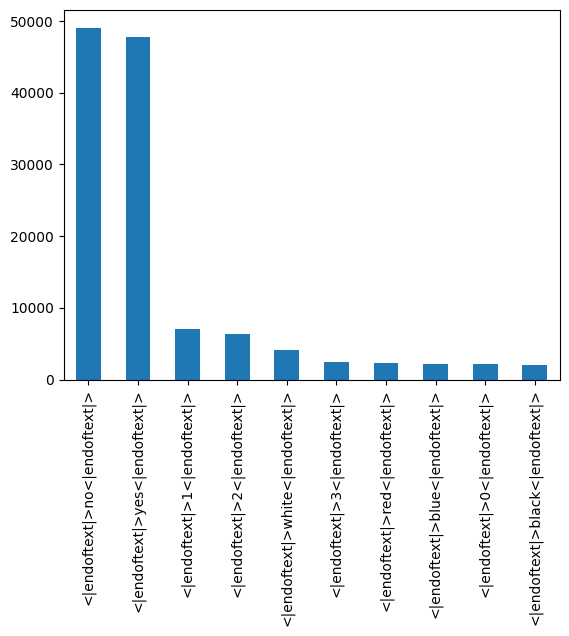

In [ ]:
import pandas as pd
pd.Series([t['answer'] for t in train_data]).value_counts().head(10).plot.bar()

In [ ]:
train_dataset = Dataset.from_dict({key: [item[key] for item in train_data] for key in train_data[0].keys()})
val_dataset = Dataset.from_dict({key: [item[key] for item in val_data] for key in val_data[0].keys()})
test_dataset = Dataset.from_dict({key: [item[key] for item in test_data] for key in test_data[0].keys()})

# Save datasets to disk (optional)
# train_dataset.save_to_disk("vqa_train_dataset")
# val_dataset.save_to_disk("vqa_val_dataset")

In [ ]:
image_feature_extractor.do_normalize = False  # controverisal pre-processing alteration

In [ ]:
def data_collator(batch, augment_image=True):
    # Preprocess and tokenize text
    text_inputs = [sample['question'] for sample in batch]
    text_tensors = text_tokenizer(text_inputs, padding=True, return_tensors="pt")

    # Augment + featurize image
    image_inputs = image_feature_extractor([preprocess_image(sample["image"], augment_image=augment_image) for sample in batch])
    image_tensors = torch.from_numpy(np.stack(image_inputs['pixel_values']))

    # Prepare decoder inputs (targets)
    target_inputs = [sample["answer"] for sample in batch]
    target_tensors = decoder_tokenizer(target_inputs, padding=True, return_tensors="pt")

    # Return input tensors
    labels = target_tensors["input_ids"].clone()
    # mask the loss on the pad tokens to not confuse the model into thinking it needs to generate pad tokens
    labels = torch.where((labels == decoder_tokenizer.pad_token_id), -100, labels)
    labels[:, -1] = decoder_tokenizer.eos_token_id

    return {
        "input_text": text_tensors["input_ids"].to(device),
        "attention_mask": text_tensors["attention_mask"].to(device),
        "input_image": image_tensors.to(device),
        "decoder_input_ids": target_tensors["input_ids"].to(device),
        "labels": labels.to(device)
    }

for i, d in enumerate(train_data):
    if len(d['answer']) > (len(train_data[0]['answer']) + 10):
        print([train_data[0]['answer'], train_data[i]['answer']])

        batch = data_collator([train_data[0], train_data[i]])
        print(batch['decoder_input_ids'])

        print(batch['labels'])
        break

['<|endoftext|>yes<|endoftext|>', '<|endoftext|>de anza college<|endoftext|>']
tensor([[50256, 50256, 50256, 50256,  8505, 50256],
        [50256,  2934,   281,  4496,  4152, 50256]], device='cuda:0')
tensor([[ -100,  -100,  -100,  -100,  8505, 50256],
        [ -100,  2934,   281,  4496,  4152, 50256]], device='cuda:0')


In [ ]:
training_args = TrainingArguments(
    output_dir="./vqa_custom",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    gradient_accumulation_steps=2,
    evaluation_strategy="epoch",
    logging_steps=10,
    fp16=True,  # only possible if using a GPU
    save_strategy='epoch',
    report_to='wandb',
    warmup_ratio=0.1,
    learning_rate=2e-5,
    lr_scheduler_type='cosine',
    save_total_limit=1,
    save_safetensors=False,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
)

class CustomTrainer(Trainer):
    def __init__(self, *args, train_dataloader=None, eval_dataloader=None, test_dataloader=None, **kwargs):
        super().__init__(*args, **kwargs)
        self._train_dataloader = train_dataloader
        self._eval_dataloader = eval_dataloader
        self._test_dataloader = test_dataloader

    def get_train_dataloader(self):
        if self._train_dataloader is not None:
            return self._train_dataloader
        return super().get_train_dataloader()

    def get_eval_dataloader(self, dataset=None):
        if self._eval_dataloader is not None:
            return self._eval_dataloader
        return super().get_eval_dataloader(dataset)

    def get_test_dataloader(self, dataset=None):
        if self._test_dataloader is not None:
            return self._test_dataloader
        return super().get_test_dataloader(dataset)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
model = MultiModalModel(
    image_encoder_model=IMAGE_ENCODER_MODEL, text_encoder_model=TEXT_ENCODER_MODEL,
    decoder_model=DECODER_MODEL, freeze='nothing')

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.

In [ ]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_trainable_params = count_trainable_parameters(model)
print(f"Number of trainable parameters: {num_trainable_params:,}")

Number of trainable parameters: 306,739,968


In [ ]:
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset, batch_size=training_args.per_device_train_batch_size,
    collate_fn=data_collator, shuffle=True,
)
eval_dataloader = DataLoader(
    val_dataset, batch_size=training_args.per_device_eval_batch_size,
    collate_fn=lambda x: data_collator(x, augment_image=False)
)
test_dataloader = DataLoader(
    test_dataset, batch_size=training_args.per_device_eval_batch_size,
    collate_fn=lambda x: data_collator(x, augment_image=False)
)

# Use the CustomTrainer class
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader
)

In [ ]:
assert model.text_encoder.device == model.image_encoder.device == model.decoder.device

answer || <|endoftext|>yes<|endoftext|>
decoder_input_ids tensor([[50256,  8505, 50256]], device='cuda:0')
model ouput ids tensor([[198,  11, 464]], device='cuda:0')
tensor(8.7810, device='cuda:0', grad_fn=<NllLossBackward0>)


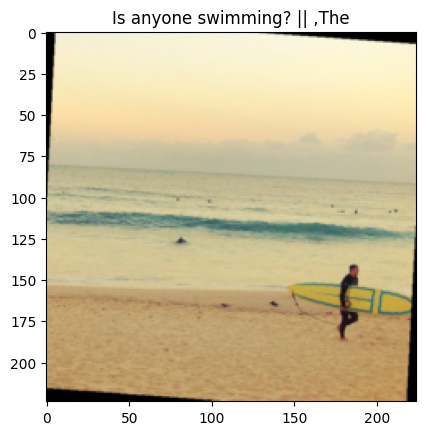

In [ ]:
v = test_dataset[1]
batch = data_collator([v])
print('answer ||', v['answer'])
print('decoder_input_ids', batch['decoder_input_ids'])
model_output = model(**batch)
output_ids = torch.argmax(model_output.logits, dim=-1)
print('model ouput ids', output_ids)
# Decode the token IDs into text
decoded_output = decoder_tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
print(model_output.loss)
# show input_image
plt.imshow(batch['input_image'][0].cpu().permute(1, 2, 0))
plt.title(f'{v["question"]} || {decoded_output}')
plt.show()

In [ ]:
trainer.evaluate()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin


{'eval_loss': 9.358777046203613,
 'eval_runtime': 161.2529,
 'eval_samples_per_second': 131.929,
 'eval_steps_per_second': 1.036}

In [ ]:
def generate_datapoint(datapoint, model, decoder_tokenizer, verbose=False):

    image, generated_answer = model.generate(
        datapoint['image'], [datapoint['question']],
        max_text_length=5, verbose=verbose
        )
    decoded_answer = datapoint['answer'].replace(decoder_tokenizer.bos_token, '').replace(decoder_tokenizer.eos_token, '').strip()
    return dict(
        generated_answer=generated_answer, answer=decoded_answer, correct=generated_answer == decoded_answer
        )

def test_model(model, decoder_tokenizer, test_dataset, verbose=False):
    results = []

    for datapoint in tqdm(test_dataset):
        results.append(generate_datapoint(datapoint, model, decoder_tokenizer, verbose=verbose))
    return results

In [ ]:
results = test_model(model, decoder_tokenizer, test_dataset.select(range(100)), verbose=False)
pd.DataFrame(results)['correct'].value_counts(normalize=True)

100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


correct
False    1.0
Name: proportion, dtype: float64

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
0,0.751500,0.765506
2,0.679900,0.667647


Epoch,Training Loss,Validation Loss
0,0.751500,0.765506
2,0.679900,0.667647


In [ ]:
test_dataset

In [ ]:
results = test_model(model, decoder_tokenizer, test_dataset, verbose=False)
pd.DataFrame(results)['correct'].value_counts(normalize=True)

 77%|███████▋  | 16418/21274 [19:33<05:35, 14.48it/s]

In [39]:
pd.DataFrame(results)['correct'].value_counts(normalize=True)

correct
False    0.530648
True     0.469352
Name: proportion, dtype: float64

In [40]:
pd.DataFrame(results)

,generated_answer,answer,correct
0,no,no,True
1,no,yes,False
2,no,yes,False
3,1,3,False
4,no,yes,False
...,...,...,...
21269,yes,yes,True
21270,2:10,98,False
21271,kite,bananas,False
21272,black and white,gray,False


In [ ]:
trainer.save_model()

In [ ]:
from huggingface_hub import HfFolder, notebook_login
notebook_login()

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!git lfs install

!GIT_LFS_SKIP_SMUDGE=1

!git clone https://huggingface.co/profoz/quick-start-llm-vqa

!cp /content/vqa_custom/pytorch_model.bin /content/quick-start-llm-vqa/
!cp /content/vqa_custom/training_args.bin /content/quick-start-llm-vqa/


In [ ]:
%cd /content/quick-start-llm-vqa/
!git config --global user.email "sinan.u.ozdemir@gmail.com"
!git config --global user.name "Sinan Ozdemir"
!git add .
!git commit -m "New VQA custom model"
!git push
